Now, we have arrived at the quantitative analysis part. As discussed before, we will work with a discrede-time hazard survival analysis model. Survival analysis works well with our objective since we want to know when/how strikes end. Also, discrete time hazard models already implement our "unknown" strikes by themselves by right-censoring. One downside is that since our event size is too small and there are not enough strikes that failed; we wont be able to use the discrete time hazard model for strike success; only for strike endings. For strike success, we will need to (unfortunately) use a logit model.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
PATH_XLSX = "Evrensel_2024_2025_found_strikes.xlsx"

df = pd.read_excel(PATH_XLSX)

print("Shape:", df.shape)
print(df.columns.tolist())
display(df.head(10))

Shape: (134, 10)
['EVENT_ID', 'FIRM', 'WORKER_TOTAL', 'WORKER_STRIKE', 'STRIKING_WORKER_RATIO', 'SECTOR', 'STRIKE_DURATION (DAYS)', 'UNION_PRESENCE', 'LEGAL_STRIKE', 'RESULT']


,EVENT_ID,FIRM,WORKER_TOTAL,WORKER_STRIKE,STRIKING_WORKER_RATIO,SECTOR,STRIKE_DURATION (DAYS),UNION_PRESENCE,LEGAL_STRIKE,RESULT
0,E0001,Akkuyu Nükleer İnşaatı (TSM Enerji),25000,13,0.052000,Construction,1,0,0,0.0
1,E0002,Eti Alüminyum,1235,750,60.728745,Metal,18,0,0,1.0
2,E0003,Cemre Tersanesi,3000,250,8.333333,"Ship building, marine warehouse",2,0,0,0.0
3,E0004,SASA İnşaat (PTS),9000,300,3.333333,Construction,4,0,0,1.0
4,E0005,MICHA,300,170,56.666667,Metal,6,1,0,1.0
5,E0006,Ulutaş Carpet,38,38,100.000000,Textile,24,1,0,1.0
6,E0007,Ender Alüminyum,175,175,100.000000,Metal,3,0,0,1.0
7,E0008,Milat Halı,1300,430,33.076923,Textile,6,1,0,1.0
8,E0009,Portakal Plastik,130,130,100.000000,Petroleum,28,1,1,1.0
9,E0010,Purmo Metal,100,100,100.000000,Metal,66,1,1,1.0


Some light cleaning and adding "ended/unknown".

In [4]:
df = df.copy()


num_cols = [
    "WORKER_TOTAL",
    "WORKER_STRIKE",
    "STRIKING_WORKER_RATIO",
    "STRIKE_DURATION (DAYS)",
    "UNION_PRESENCE",
    "LEGAL_STRIKE",
    "RESULT",
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


df["ended_known"] = df["RESULT"].isin([0, 1]).astype(int)     
df["censored_unknown"] = df["RESULT"].isna().astype(int)      


df["duration_days"] = df["STRIKE_DURATION (DAYS)"].astype("Int64")


df = df.dropna(subset=["EVENT_ID", "duration_days", "SECTOR"]).copy()
df = df[df["duration_days"] >= 1].copy()

print("N strikes:", len(df))
print("Known-ended:", int(df["ended_known"].sum()))
print("Unknown/censored:", int(df["censored_unknown"].sum()))
display(df[["EVENT_ID", "SECTOR", "duration_days", "RESULT", "ended_known", "censored_unknown"]].head(12))


N strikes: 134
Known-ended: 103
Unknown/censored: 31


,EVENT_ID,SECTOR,duration_days,RESULT,ended_known,censored_unknown
0,E0001,Construction,1,0.0,1,0
1,E0002,Metal,18,1.0,1,0
2,E0003,"Ship building, marine warehouse",2,0.0,1,0
3,E0004,Construction,4,1.0,1,0
4,E0005,Metal,6,1.0,1,0
5,E0006,Textile,24,1.0,1,0
6,E0007,Metal,3,1.0,1,0
7,E0008,Textile,6,1.0,1,0
8,E0009,Petroleum,28,1.0,1,0
9,E0010,Metal,66,1.0,1,0


Since our STRIKING_WORKER_RATIO was percentages, we will normalize it to proportion. Also, we will scale WORKER_TOTAL since there are huge discrepencies among the strikes. We will also check covariates.

In [5]:
df["log_total_workers"] = np.log(df["WORKER_TOTAL"].replace(0, np.nan))

# Make sector categorical
df["SECTOR"] = df["SECTOR"].astype("category")

# Keep a compact modeling frame
cov_cols = ["SECTOR", "LEGAL_STRIKE", "UNION_PRESENCE", "log_total_workers", "STRIKING_WORKER_RATIO"]
print("Missingness in covariates:")
print(df[cov_cols].isna().mean().sort_values(ascending=False))

display(df[cov_cols + ["duration_days", "RESULT"]].head(10))

df["STRIKING_WORKER_RATIO"] = df["STRIKING_WORKER_RATIO"] / 100.0

df["STRIKING_WORKER_RATIO"]

Missingness in covariates:
SECTOR                   0.0
LEGAL_STRIKE             0.0
UNION_PRESENCE           0.0
log_total_workers        0.0
STRIKING_WORKER_RATIO    0.0
dtype: float64


,SECTOR,LEGAL_STRIKE,UNION_PRESENCE,log_total_workers,STRIKING_WORKER_RATIO,duration_days,RESULT
0,Construction,0,0,10.126631,0.052000,1,0.0
1,Metal,0,0,7.118826,60.728745,18,1.0
2,"Ship building, marine warehouse",0,0,8.006368,8.333333,2,0.0
3,Construction,0,0,9.104980,3.333333,4,1.0
4,Metal,0,1,5.703782,56.666667,6,1.0
5,Textile,0,1,3.637586,100.000000,24,1.0
6,Metal,0,0,5.164786,100.000000,3,1.0
7,Textile,0,1,7.170120,33.076923,6,1.0
8,Petroleum,1,1,4.867534,100.000000,28,1.0
9,Metal,1,1,4.605170,100.000000,66,1.0


,STRIKING_WORKER_RATIO
0,0.000520
1,0.607287
2,0.083333
3,0.033333
4,0.566667
...,...
129,0.900000
130,0.863636
131,0.205556
132,0.181818


No missing covariates, which is good. Now, we will create the person-day dataframe for survival analysis.

In [6]:
def expand_to_person_day(df_strike_level: pd.DataFrame) -> pd.DataFrame:
 
    out = []

    for _, r in df_strike_level.iterrows():
        sid = r["EVENT_ID"]
        T = int(r["duration_days"])
        ended = int(r["ended_known"])

        # event_end: only last day if ended_known
        event_end = np.zeros(T, dtype=int)
        if ended == 1:
            event_end[-1] = 1

        tmp = pd.DataFrame({
            "EVENT_ID": sid,
            "t": np.arange(1, T + 1),
            "event_end": event_end,
        })

        # time-invariant covariates copied down
        tmp["SECTOR"] = r["SECTOR"]
        tmp["LEGAL_STRIKE"] = r["LEGAL_STRIKE"]
        tmp["UNION_PRESENCE"] = r["UNION_PRESENCE"]
        tmp["log_total_workers"] = r["log_total_workers"]
        tmp["STRIKING_WORKER_RATIO"] = r["STRIKING_WORKER_RATIO"]

        # keep result for later (success model), but it's strike-level
        tmp["RESULT"] = r["RESULT"]
        tmp["ended_known"] = ended

        out.append(tmp)

    return pd.concat(out, ignore_index=True)

df_pd = expand_to_person_day(df)

print("Person-day rows:", len(df_pd))
display(df_pd.head(15))


Person-day rows: 5207


,EVENT_ID,t,event_end,SECTOR,LEGAL_STRIKE,UNION_PRESENCE,log_total_workers,STRIKING_WORKER_RATIO,RESULT,ended_known
0,E0001,1,1,Construction,0,0,10.126631,0.000520,0.0,1
1,E0002,1,0,Metal,0,0,7.118826,0.607287,1.0,1
2,E0002,2,0,Metal,0,0,7.118826,0.607287,1.0,1
3,E0002,3,0,Metal,0,0,7.118826,0.607287,1.0,1
4,E0002,4,0,Metal,0,0,7.118826,0.607287,1.0,1
5,E0002,5,0,Metal,0,0,7.118826,0.607287,1.0,1
6,E0002,6,0,Metal,0,0,7.118826,0.607287,1.0,1
7,E0002,7,0,Metal,0,0,7.118826,0.607287,1.0,1
8,E0002,8,0,Metal,0,0,7.118826,0.607287,1.0,1
9,E0002,9,0,Metal,0,0,7.118826,0.607287,1.0,1


Creating time bins. We did not need to drop missing covariates (since there are none), but it is kept as a failsafe

In [7]:
df_pd = df_pd.copy()

bins = [0, 3, 7, 14, 30, 60, 90, 180, 365, 10_000]
labels = ["1-3", "4-7", "8-14", "15-30", "31-60", "61-90", "91-180", "181-365", "366+"]

df_pd["time_bin"] = pd.cut(
    df_pd["t"], bins=bins, labels=labels, include_lowest=True, right=True
)

need = ["event_end", "time_bin", "SECTOR", "LEGAL_STRIKE", "UNION_PRESENCE", "log_total_workers", "STRIKING_WORKER_RATIO", "EVENT_ID"]
df_model = df_pd.dropna(subset=need).copy()

print("Rows used in hazard model:", len(df_model))
print(df_model["time_bin"].value_counts())


Rows used in hazard model: 5207
time_bin
181-365    920
91-180     800
31-60      798
15-30      637
366+       577
61-90      486
8-14       364
1-3        335
4-7        290
Name: count, dtype: int64


We will now build the discrete time hazard model (using clusters) and fit our model to our data.

In [8]:
formula_h = (
    "event_end ~ C(time_bin) + C(SECTOR) + "
    "LEGAL_STRIKE + UNION_PRESENCE + log_total_workers + STRIKING_WORKER_RATIO"
)

haz_mod = smf.glm(
    formula=formula_h,
    data=df_model,
    family=sm.families.Binomial()
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_model["EVENT_ID"]}
)

print(haz_mod.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              event_end   No. Observations:                 5207
Model:                            GLM   Df Residuals:                     5178
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -414.89
Date:                Tue, 20 Jan 2026   Deviance:                       829.79
Time:                        10:55:41   Pearson chi2:                 5.18e+03
No. Iterations:                    24   Pseudo R-squ. (CS):            0.03441
Covariance Type:              cluster                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [9]:
params = haz_mod.params
conf = haz_mod.conf_int()

or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1]),
    "pvalue": haz_mod.pvalues
}).sort_values("pvalue")

display(or_table.head(40))


,coef,OR,CI_low,CI_high,pvalue
C(SECTOR)[T.Glass],-20.360163,1.437783e-09,2.845348e-10,7.265266e-09,5.627040e-134
Intercept,-4.181450,1.527633e-02,3.110756e-03,7.501918e-02,2.608517e-07
C(time_bin)[T.181-365],-3.058501,4.695801e-02,1.417222e-02,1.555899e-01,5.617440e-07
C(SECTOR)[T.Transportation],3.683775,3.979635e+01,7.676597e+00,2.063088e+02,1.146604e-05
"C(SECTOR)[T.Ship building, marine warehouse]",3.379989,2.937046e+01,6.080024e+00,1.418784e+02,2.597200e-05
C(time_bin)[T.366+],-1.902574,1.491841e-01,6.121536e-02,3.635671e-01,2.836884e-05
C(time_bin)[T.91-180],-2.216995,1.089359e-01,3.188070e-02,3.722326e-01,4.058105e-04
C(time_bin)[T.61-90],-2.018774,1.328182e-01,3.980936e-02,4.431287e-01,1.023745e-03
C(time_bin)[T.31-60],-1.272111,2.802395e-01,1.269234e-01,6.187527e-01,1.644749e-03
C(SECTOR)[T.Bureau],1.691730,5.428867e+00,1.766458e+00,1.668458e+01,3.144865e-03


This is very informative. Let us start from the top. The OR of glass sector indicates that there is a seperation issue, there are simply not enough examples. Indeed, there are only 2 or 3 events of this type in our data. Thus, we must disregard it event if the p value is significant at the 1% level. For the time bins, we can see that OR levels are really low in the bucket 181-365 compared to the other buckets. This means, more or less, strikes getting through day 181 will most likely see day 365. On a more general note, we observe that strikes that get past 2 weeks become increasingly more unlikely to end on a given day. The OR scores of the other sectors show that the strikes most likely to end at any given day are in the transportation sector, with the least likely being the entertainment sector. The OR of log_workers point towards strikes at larger firms ending faster. Also it can be said that unionized strikes last longer, albeit with borderline significance. Surprisingly, neither the striking worker ratio nor the legality of strikes are statistically significant. The legality of strikes could be having filtered out by union presence and sectors (union presence most likely, since all legal strikes have to have a union).

Now, we add predicted hazard to construct a baseline hazard model to compare different variables.

In [10]:
df_model = df_model.copy()
df_model["pred_hazard"] = haz_mod.predict(df_model)

baseline = (
    df_model.groupby("time_bin", observed=True)
    .agg(
        n=("pred_hazard", "size"),
        mean_pred_hazard=("pred_hazard", "mean"),
        raw_end_rate=("event_end", "mean"),
        mean_t=("t", "mean")
    )
    .reset_index()
)

display(baseline)


,time_bin,n,mean_pred_hazard,raw_end_rate,mean_t
0,1-3,335,0.107463,0.107463,1.889552
1,4-7,290,0.065517,0.065517,5.365517
2,8-14,364,0.021978,0.021978,10.873626
3,15-30,637,0.020408,0.020408,21.850863
4,31-60,798,0.016291,0.016291,43.994987
5,61-90,486,0.008230,0.008230,75.181070
6,91-180,800,0.006250,0.006250,129.078750
7,181-365,920,0.002174,0.002174,265.359783
8,366+,577,0.005199,0.005199,462.438475


The baseline according to time bins confirms our intiution. Strikes that are not resolved early have less and less chance of being resolved over time.

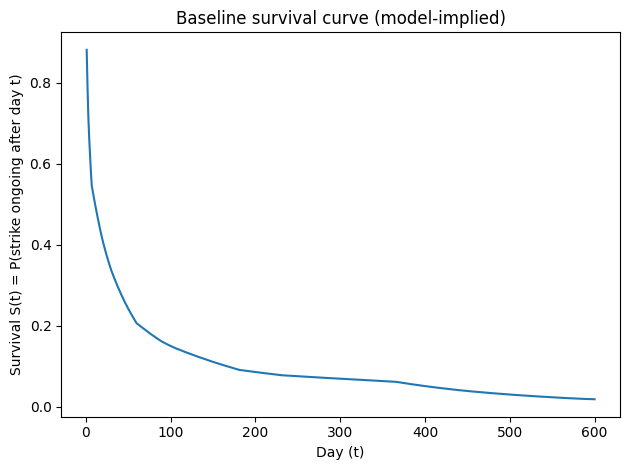

,t,pred_hazard,survival
0,1,0.118344,0.881656
1,2,0.103979,0.789982
2,3,0.096165,0.714013
3,4,0.072191,0.662468
4,5,0.065603,0.619008


In [11]:

import matplotlib.pyplot as plt

# df_model must exist (person-day estimation data)
# haz_mod must exist (fitted GLM)

# Predict hazard for each observed person-day row
df_pred = df_model.copy()
df_pred["pred_hazard"] = haz_mod.predict(df_pred)

# Baseline (average over observed covariate distribution) hazard-by-day
base_by_t = (
    df_pred.groupby("t")["pred_hazard"]
    .mean()
    .reset_index()
    .sort_values("t")
)

# Convert hazards to survival: S(t) = Π(1 - h(t))
base_by_t["survival"] = (1 - base_by_t["pred_hazard"]).cumprod()

# Plot baseline survival
plt.figure()
plt.plot(base_by_t["t"], base_by_t["survival"])
plt.xlabel("Day (t)")
plt.ylabel("Survival S(t) = P(strike ongoing after day t)")
plt.title("Baseline survival curve (model-implied)")
plt.tight_layout()
plt.show()

base_by_t.head()


The visualization again confirms our intuition: Low survival of strikes initially, high survival over time. Now, we will construct a counterfactual survival curve to measure different categories against one another, by constructing scenarios where all of the events are at that category and vice-versa.

In [12]:
def survival_curve_under_setting(df_template: pd.DataFrame, **set_cols) -> pd.DataFrame:
 
    tmp = df_template.copy()
    for col, val in set_cols.items():
        tmp[col] = val

    tmp["pred_hazard"] = haz_mod.predict(tmp)

    by_t = (
        tmp.groupby("t")["pred_hazard"]
        .mean()
        .reset_index()
        .sort_values("t")
    )
    by_t["survival"] = (1 - by_t["pred_hazard"]).cumprod()
    return by_t


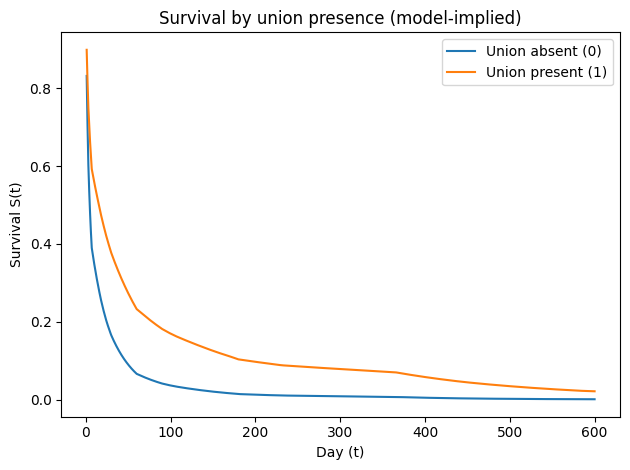

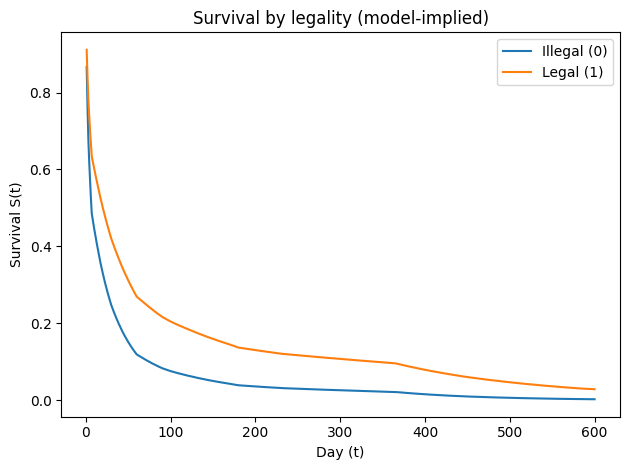

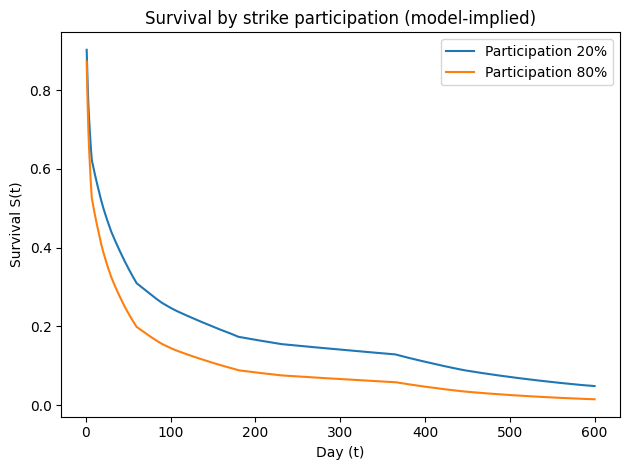

In [13]:

template = df_model.copy()


S_union0 = survival_curve_under_setting(template, UNION_PRESENCE=0)
S_union1 = survival_curve_under_setting(template, UNION_PRESENCE=1)

plt.figure()
plt.plot(S_union0["t"], S_union0["survival"], label="Union absent (0)")
plt.plot(S_union1["t"], S_union1["survival"], label="Union present (1)")
plt.xlabel("Day (t)")
plt.ylabel("Survival S(t)")
plt.title("Survival by union presence (model-implied)")
plt.legend()
plt.tight_layout()
plt.show()


S_legal0 = survival_curve_under_setting(template, LEGAL_STRIKE=0)
S_legal1 = survival_curve_under_setting(template, LEGAL_STRIKE=1)

plt.figure()
plt.plot(S_legal0["t"], S_legal0["survival"], label="Illegal (0)")
plt.plot(S_legal1["t"], S_legal1["survival"], label="Legal (1)")
plt.xlabel("Day (t)")
plt.ylabel("Survival S(t)")
plt.title("Survival by legality (model-implied)")
plt.legend()
plt.tight_layout()
plt.show()


S_part_low = survival_curve_under_setting(template, STRIKING_WORKER_RATIO=0.20)
S_part_high = survival_curve_under_setting(template, STRIKING_WORKER_RATIO=0.80)

plt.figure()
plt.plot(S_part_low["t"], S_part_low["survival"], label="Participation 20%")
plt.plot(S_part_high["t"], S_part_high["survival"], label="Participation 80%")
plt.xlabel("Day (t)")
plt.ylabel("Survival S(t)")
plt.title("Survival by strike participation (model-implied)")
plt.legend()
plt.tight_layout()
plt.show()


These results are highly informative. We can see that strikes with unions tend to survive better, legal strikes tend to survive better and lower participation tends to survive better. The first two we have talked about, what about the last one? One reason may be that low participation strikes usually dont affect the employer that much, so they just dont care; leaving the workers in a limbo where they are on strike until their strike eventually fizzles out.

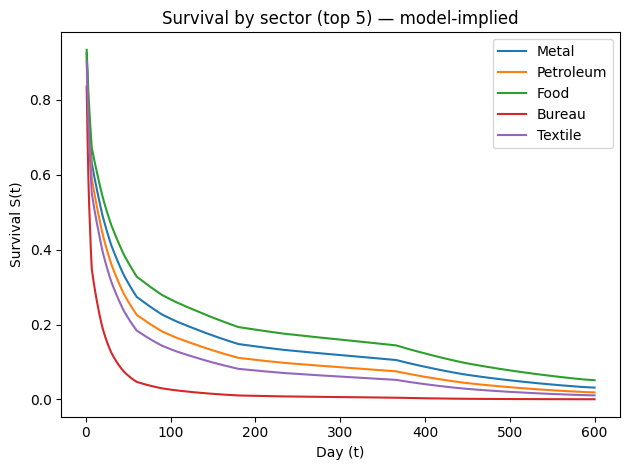

In [14]:

K = 5
top_sectors = df_model["SECTOR"].value_counts().head(K).index.tolist()

curves = {}
for s in top_sectors:
    curves[s] = survival_curve_under_setting(df_model, SECTOR=s)

plt.figure()
for s, curve in curves.items():
    plt.plot(curve["t"], curve["survival"], label=str(s))
plt.xlabel("Day (t)")
plt.ylabel("Survival S(t)")
plt.title(f"Survival by sector (top {K}) — model-implied")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
def survival_at(curve: pd.DataFrame, days=(30, 60, 90, 180)):
    out = {}
    for d in days:
        # nearest day <= d
        sub = curve[curve["t"] <= d]
        out[d] = float(sub["survival"].iloc[-1]) if len(sub) else np.nan
    return out

rows = []


rows.append({"Comparison": "Union 0", **survival_at(S_union0)})
rows.append({"Comparison": "Union 1", **survival_at(S_union1)})


rows.append({"Comparison": "Legal 0", **survival_at(S_legal0)})
rows.append({"Comparison": "Legal 1", **survival_at(S_legal1)})


rows.append({"Comparison": "Participation 20%", **survival_at(S_part_low)})
rows.append({"Comparison": "Participation 80%", **survival_at(S_part_high)})

summary_table = pd.DataFrame(rows)
display(summary_table)


,Comparison,30,60,90,180
0,Union 0,0.165216,0.065960,0.041072,0.014008
1,Union 1,0.377014,0.232420,0.181360,0.103196
2,Legal 0,0.247814,0.119561,0.083752,0.039347
3,Legal 1,0.420439,0.269606,0.217180,0.137278
4,Participation 20%,0.440574,0.309406,0.259350,0.173371
5,Participation 80%,0.324939,0.198461,0.155069,0.088310


Now, we can move onto success regression.

In [16]:
df_out = df.copy()
df_out = df_out[df_out["ended_known"] == 1].copy()

df_out["success"] = df_out["RESULT"].astype(int)  
df_out["log_duration"] = np.log(df_out["duration_days"])


need2 = ["success", "SECTOR", "LEGAL_STRIKE", "UNION_PRESENCE", "log_total_workers", "STRIKING_WORKER_RATIO", "log_duration"]
df_out2 = df_out.dropna(subset=need2).copy()

print("Ended strikes used in success model:", len(df_out2))
print(df_out2["success"].value_counts())
display(df_out2.head(10))


Ended strikes used in success model: 103
success
1    78
0    25
Name: count, dtype: int64


,EVENT_ID,FIRM,WORKER_TOTAL,WORKER_STRIKE,STRIKING_WORKER_RATIO,SECTOR,STRIKE_DURATION (DAYS),UNION_PRESENCE,LEGAL_STRIKE,RESULT,ended_known,censored_unknown,duration_days,log_total_workers,success,log_duration
0,E0001,Akkuyu Nükleer İnşaatı (TSM Enerji),25000,13,0.000520,Construction,1,0,0,0.0,1,0,1,10.126631,0,0.0
1,E0002,Eti Alüminyum,1235,750,0.607287,Metal,18,0,0,1.0,1,0,18,7.118826,1,2.890372
2,E0003,Cemre Tersanesi,3000,250,0.083333,"Ship building, marine warehouse",2,0,0,0.0,1,0,2,8.006368,0,0.693147
3,E0004,SASA İnşaat (PTS),9000,300,0.033333,Construction,4,0,0,1.0,1,0,4,9.104980,1,1.386294
4,E0005,MICHA,300,170,0.566667,Metal,6,1,0,1.0,1,0,6,5.703782,1,1.791759
5,E0006,Ulutaş Carpet,38,38,1.000000,Textile,24,1,0,1.0,1,0,24,3.637586,1,3.178054
6,E0007,Ender Alüminyum,175,175,1.000000,Metal,3,0,0,1.0,1,0,3,5.164786,1,1.098612
7,E0008,Milat Halı,1300,430,0.330769,Textile,6,1,0,1.0,1,0,6,7.170120,1,1.791759
8,E0009,Portakal Plastik,130,130,1.000000,Petroleum,28,1,1,1.0,1,0,28,4.867534,1,3.332205
9,E0010,Purmo Metal,100,100,1.000000,Metal,66,1,1,1.0,1,0,66,4.605170,1,4.189655


Unfortunately, we have only 103 ended events. So, we shoul be careful about interpreting these statistics. Since our data is so small, we must collapse all sectors which have no variance to their results; since already their number is really low.

In [17]:

sector_outcome_var = (
    df_out2.groupby("SECTOR", observed=False)["success"].nunique()
)
bad_sectors = sector_outcome_var[sector_outcome_var < 2].index

sector_counts = df_out2["SECTOR"].value_counts()
rare_sectors = sector_counts[sector_counts < 5].index

collapse = set(bad_sectors) | set(rare_sectors)


df_out2["SECTOR_C"] = df_out2["SECTOR"].astype(str)

df_out2.loc[
    df_out2["SECTOR_C"].isin(collapse),
    "SECTOR_C"
] = "Other"


df_out2["SECTOR_C"] = df_out2["SECTOR_C"].astype("category")

print("Original sectors:", df_out2["SECTOR"].nunique())
print("Collapsed sectors:", df_out2["SECTOR_C"].nunique())
print(df_out2["SECTOR_C"].value_counts())


Original sectors: 16
Collapsed sectors: 6
SECTOR_C
Bureau       23
Metal        20
Other        20
Textile      18
Petroleum    16
Food          6
Name: count, dtype: int64


We have succesfully dropped from 16 to 6 sectors. Now, lets fit our model.

In [18]:

binary_preds = []
for p in ["LEGAL_STRIKE", "UNION_PRESENCE"]:
    if df_out2[p].nunique() > 1:
        binary_preds.append(p)

print("Binary predictors used:", binary_preds)

formula_success_T = (
    "success ~ C(SECTOR_C) + " +
    " + ".join(binary_preds + ["log_total_workers", "STRIKING_WORKER_RATIO", "log_duration"])
)

succ_mod_T = smf.glm(
    formula=formula_success_T,
    data=df_out2,
    family=sm.families.Binomial()
).fit(cov_type="HC1")

print(succ_mod_T.summary())


Binary predictors used: ['LEGAL_STRIKE', 'UNION_PRESENCE']
                 Generalized Linear Model Regression Results                  
Dep. Variable:                success   No. Observations:                  103
Model:                            GLM   Df Residuals:                       92
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41.093
Date:                Tue, 20 Jan 2026   Deviance:                       82.185
Time:                        10:55:42   Pearson chi2:                     101.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2669
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [19]:
params = succ_mod_T.params
conf = succ_mod_T.conf_int()

or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1]),
    "pvalue": succ_mod_T.pvalues
}).sort_values("pvalue")

display(or_table.head(30))


,coef,OR,CI_low,CI_high,pvalue
STRIKING_WORKER_RATIO,3.214418,24.888797,3.138368,197.380364,0.002346
C(SECTOR_C)[T.Metal],1.866946,6.468514,1.299658,32.194366,0.022604
Intercept,-4.140184,0.015920,0.000288,0.880984,0.043192
log_duration,-0.407541,0.665284,0.444780,0.995106,0.047273
C(SECTOR_C)[T.Textile],2.234688,9.343569,0.973905,89.641437,0.052740
UNION_PRESENCE,1.298728,3.664632,0.759676,17.677974,0.105746
LEGAL_STRIKE,1.030006,2.801083,0.800013,9.807416,0.107184
C(SECTOR_C)[T.Petroleum],2.088613,8.073708,0.514500,126.695293,0.137049
C(SECTOR_C)[T.Food],1.462558,4.316990,0.532725,34.983130,0.170672
log_total_workers,0.249891,1.283886,0.833070,1.978661,0.257484


Now, what we have here is interesting. As expected, striking working ratio has a great effect on strike success rates at a significant level. Metal sector strikes are also associated with success. We can also see that as strikes go on, the probability of success decreases. Interestingly; both union presence and legal strike are not significant at the 10% level. This is highly a result of multicollinearity.